In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import mdtraj as md
import h5py
import pandas as pd
import sys
sys.path.append('../')
import fnmatch
from matplotlib import cm
import pickle
from matplotlib.colors import PowerNorm
from matplotlib.lines import Line2D

In [2]:
#import matplotlib_config as cfg

In [3]:
step2us = 2e-9
burst = 1e5

In [4]:
def calculate_blocked_means(data, n_blocks):
    n = len(data)
    
    # Handle edge cases
    if n_blocks <= 0:
        raise ValueError("n_blocks must be positive")
    if n_blocks > n:
        n_blocks = n  # Cannot have more blocks than data points
    
    blocked_means = []
    block_size = n // n_blocks  # Use n_blocks, not n_blocks-1
    
    # Distribute remainder across first few blocks
    remainder = n % n_blocks
    starts = [0]
    
    # Calculate start indices considering remainder distribution
    for i in range(1, n_blocks):
        extra = 1 if i <= remainder else 0
        starts.append(starts[-1] + block_size + extra)
    
    # Create blocks with proper boundaries
    for i in range(n_blocks):
        start = starts[i]
        end = starts[i+1] if i < n_blocks - 1 else n
        data_block = data[start:end]
        
        # Only calculate mean if block has data
        if len(data_block) > 0:
            mean = np.mean(data_block, axis=0)
            blocked_means.append(mean)
    
    return np.array(blocked_means)

In [5]:
padding_n = 100

In [6]:
nblocks = 5

## Always Accepting

In [7]:
Ls_padded_AA_ = np.load('data/LOPS_padded_AA.npy')
Ls_padded_AA = np.pad(Ls_padded_AA_, ((0, 0), (0, padding_n)))
ages_of_oldest_paths_AA = np.load('data/ages_AA.npy')

avg_force_eval_per_acc_AA = np.load('data/avg_force_eval_per_acc_AA.npy')
avg_force_eval_per_trial_AA = np.load('data/avg_force_eval_per_acc_AA.npy')
full_path_lengths_AA = np.load('data/full_path_lengths_AA.npy')
avg_full_path_length_AA  = np.mean(full_path_lengths_AA)

In [8]:
print(f'per acc: {avg_force_eval_per_acc_AA}')
print(f'per trial: {avg_force_eval_per_trial_AA}')

per acc: 44037307.29701953
per trial: 44037307.29701953


In [9]:
blocked_means_AA = calculate_blocked_means(Ls_padded_AA, nblocks)

In [10]:
N_AA = blocked_means_AA.shape[0]
avg_length_padded_AA = np.mean(blocked_means_AA, axis = 0) #* step2us
std_error_padded_AA = np.std(blocked_means_AA, axis = 0)  #* step2us  / np.sqrt(N_AA)

avg_age_AA = np.mean(ages_of_oldest_paths_AA)

In [11]:
print(avg_age_AA * avg_force_eval_per_acc_AA )

478238881.14482963


## One-way Shooting

In [12]:
Ls_padded_1w_ = np.load('data/LOPS_padded_1w.npy')
Ls_padded_1w = np.pad(Ls_padded_1w_, ((0, 0), (0, padding_n)))
ages_of_oldest_paths_1w = np.load('data/ages_1w.npy')


avg_force_eval_per_acc_1w = np.load('data/avg_force_eval_per_acc_1w.npy')
avg_force_eval_per_trial_1w = np.load('data/avg_force_eval_per_trial_1w.npy')
full_path_lengths_1w = np.load('data/full_path_lengths_1w.npy')
avg_full_path_length_1w  = np.mean(full_path_lengths_1w)

In [13]:
print(f'per acc: {avg_force_eval_per_acc_1w}')
print(f'per trial: {avg_force_eval_per_trial_1w}')

per acc: 113437765.95744681
per trial: 47455081.96721312


In [14]:
blocked_means_1w = calculate_blocked_means(Ls_padded_1w, nblocks)

In [15]:
N_1w = blocked_means_1w.shape[0]
avg_length_padded_1w = np.mean(blocked_means_1w, axis = 0) #* step2us
std_error_padded_1w = np.std(blocked_means_1w, axis = 0)  #* step2us  / np.sqrt(N_1w)

avg_age_1w = np.mean(ages_of_oldest_paths_1w)

In [16]:
print(avg_full_path_length_AA)
print(avg_full_path_length_1w)

105551490.23638232
96252786.8852459


In [17]:
print(avg_age_1w * avg_force_eval_per_acc_1w )

1651432944.856164


## Combined Plot

In [18]:
# Colormaps
import matplotlib.colors as mcolors 
from cmap import Colormap

cm1_name = 'cmasher:guppy'


cm = Colormap(f'{cm1_name}')
mpl_cm = cm.to_mpl()#.reversed()

cmap_colors = mpl_cm(np.linspace(0, 1, 100))
#truncate_point = 0.1

#truncated_colors = cmap_colors[int(256 * truncate_point):]
#cmap1 = mcolors.LinearSegmentedColormap.from_list('truncated_cmap', truncated_colors)

In [19]:
plt.rcParams.update({
    'font.size': 18,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'legend.frameon': False,
    'axes.grid': False,
    'font.family': 'sans-serif'
})

/scratch_local/ipykernel_1678737/3882492127.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  inset.set_xticklabels(['0', '', '40'])


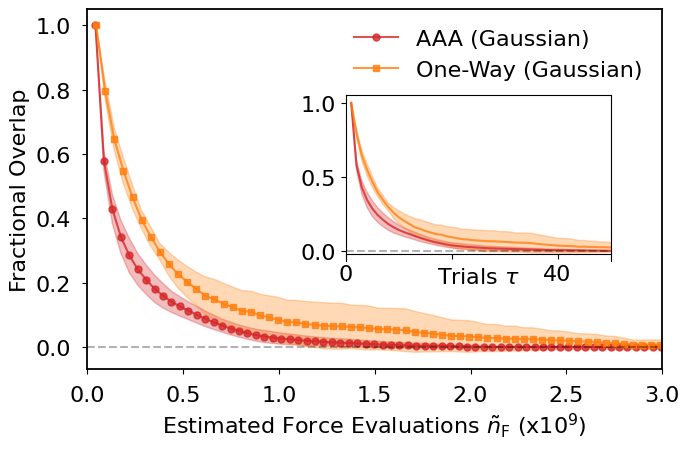

In [20]:
fig, ax = plt.subplots(figsize=(7, 4.6))

# Main plot (same as before)
xAA = (np.arange(len(avg_length_padded_AA)) + 1) 
xAA_scaled = xAA * avg_force_eval_per_trial_AA
x1w = (np.arange(len(avg_length_padded_1w)) + 1) 
x1w_scaled = x1w * avg_force_eval_per_trial_1w

ax.plot(xAA_scaled * 10**-9, avg_length_padded_AA,  'o-', color = '#d62728', alpha = 0.8, label = 'AAA (Gaussian)', ms = 5)
ax.plot(x1w_scaled * 10**-9, avg_length_padded_1w,  's-', c = '#ff7f0e', alpha = 0.8, label = 'One-Way (Gaussian)', ms = 5)

ax.fill_between(xAA_scaled * 10**-9, 
                (avg_length_padded_AA) - (std_error_padded_AA),
                (avg_length_padded_AA) + (std_error_padded_AA),
                color='#d62728', alpha=0.3, label='_nolegend_')

ax.fill_between(x1w_scaled * 10**-9, 
                (avg_length_padded_1w) - (std_error_padded_1w),
                (avg_length_padded_1w) + (std_error_padded_1w),
                color='#ff7f0e', alpha=0.3, label='_nolegend_')

ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.tick_params(axis='x', pad=8)
ax.tick_params(axis='y', pad=8)

ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

ax.set_xlabel(r'Estimated Force Evaluations $\tilde{n}_\mathrm{F}$ (x10$^9$)')
ax.set_ylabel(r'Fractional Overlap')

for spine in ax.spines.values():
    spine.set_linewidth(1.3) 
    
plt.legend()                                                                                                                                
plt.xlim(0, 3)

# Create inset axes (position: [x, y, width, height] in figure coordinates)
inset = ax.inset_axes([0.45, 0.3, 0.46, 0.46])  # Adjust position/size as needed

# Opaque background to hide main ticks behind inset
inset.set_facecolor('white')
inset.patch.set_alpha(1)

# Plot the same data in the inset WITHOUT multiplying x by 10**-9
inset.plot(xAA, avg_length_padded_AA, color='#d62728', alpha=0.8, label='AAA (Gaussian)')
inset.plot(x1w, avg_length_padded_1w, c='#ff7f0e', alpha=0.8, label='One-Way (Gaussian)')

inset.fill_between(xAA, 
                   (avg_length_padded_AA) - (std_error_padded_AA),
                   (avg_length_padded_AA) + (std_error_padded_AA),
                   color='#d62728', alpha=0.3, label='_nolegend_')

inset.fill_between(x1w, 
                   (avg_length_padded_1w) - (std_error_padded_1w),
                   (avg_length_padded_1w) + (std_error_padded_1w),
                   color='#ff7f0e', alpha=0.3, label='_nolegend_')

inset.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Set inset properties
inset.set_xlim(0, 50)  # x-range in trial units
inset.set_ylim(ax.get_ylim())  # Match main plot's y-axis range
inset.set_xlabel(r'Trials $\tau$', fontsize=16, labelpad=-12)
inset.set_xticklabels(['0', '', '40'])
inset.tick_params(axis='both', which='major', labelsize=16)

# Move x-axis closer (inside inset)
inset.spines['bottom'].set_position(('outward', -5))  # -5 = shift upward inside

# Inset formatting
inset.xaxis.get_offset_text().set_fontsize(8)

plt.tight_layout(pad=0.6) 
plt.savefig(f'../figures/oldest_path_segment_length.png', dpi=1200)

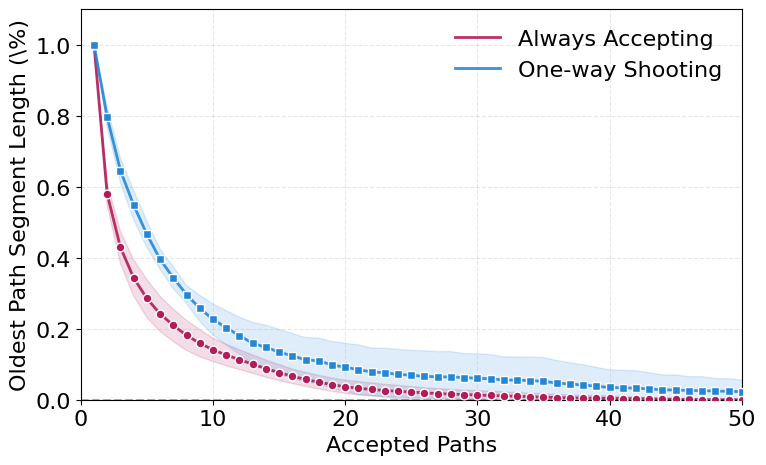

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))

# Calculate x-values
xAA = (np.arange(len(avg_length_padded_AA)) + 1) #* avg_force_eval_per_acc_AA
x1w = (np.arange(len(avg_length_padded_1w)) + 1) #* avg_force_eval_per_acc_1w

# Uncertainty bands (shaded regions)
ax.fill_between(xAA, 
               (avg_length_padded_AA) - (std_error_padded_AA),
               (avg_length_padded_AA) + (std_error_padded_AA),
               color=cmap_colors[30], alpha=0.15, label='_nolegend_')

ax.fill_between(x1w, 
               (avg_length_padded_1w) - (std_error_padded_1w),
               (avg_length_padded_1w) + (std_error_padded_1w),
               color=cmap_colors[80], alpha=0.15, label='_nolegend_')

# Lines and markers with distinct styles
ax.plot(xAA, avg_length_padded_AA, 
        color=cmap_colors[30], alpha=0.9, linestyle='-', linewidth=2, 
        label='Always Accepting')
ax.scatter(xAA, avg_length_padded_AA, 
           color=cmap_colors[30], s=40, marker='o', edgecolor='w', zorder=3)

ax.plot(x1w, avg_length_padded_1w, 
        color=cmap_colors[80], alpha=0.9, linestyle='-', linewidth=2, 
        label='One-way Shooting')
ax.scatter(x1w, avg_length_padded_1w, 
           color=cmap_colors[80], s=40, marker='s', edgecolor='w', zorder=3)

# Reference line and grid
ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax.grid(True, linestyle='--', alpha=0.3)

# Axis labels and limits
ax.set_xlabel(r'Accepted Paths')
ax.set_ylabel(r'Oldest Path Segment Length (\%)')
#plt.xlim(0, 0.15e10)
plt.xlim(0, 50)

# Adjust y-axis to focus on relevant range
y_min = min((avg_length_padded_AA).min(), 
            (avg_length_padded_1w).min()) * 0.9
y_max = max((avg_length_padded_AA).max(), 
            (avg_length_padded_1w).max()) * 1.1
ax.set_ylim(y_min, y_max)

# Legend placement
ax.legend()#loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False)

plt.tight_layout()
#plt.savefig('../figures/oldest_path_segment_length.png', dpi=300, bbox_inches='tight')
plt.savefig('../figures/oldest_path_segment_length_per_age.png', dpi=300, bbox_inches='tight')

In [22]:
import matplotlib.colors as mcolors 
from cmap import Colormap

cm = Colormap('cmocean:dense')
mpl_cm = cm.to_mpl().reversed()

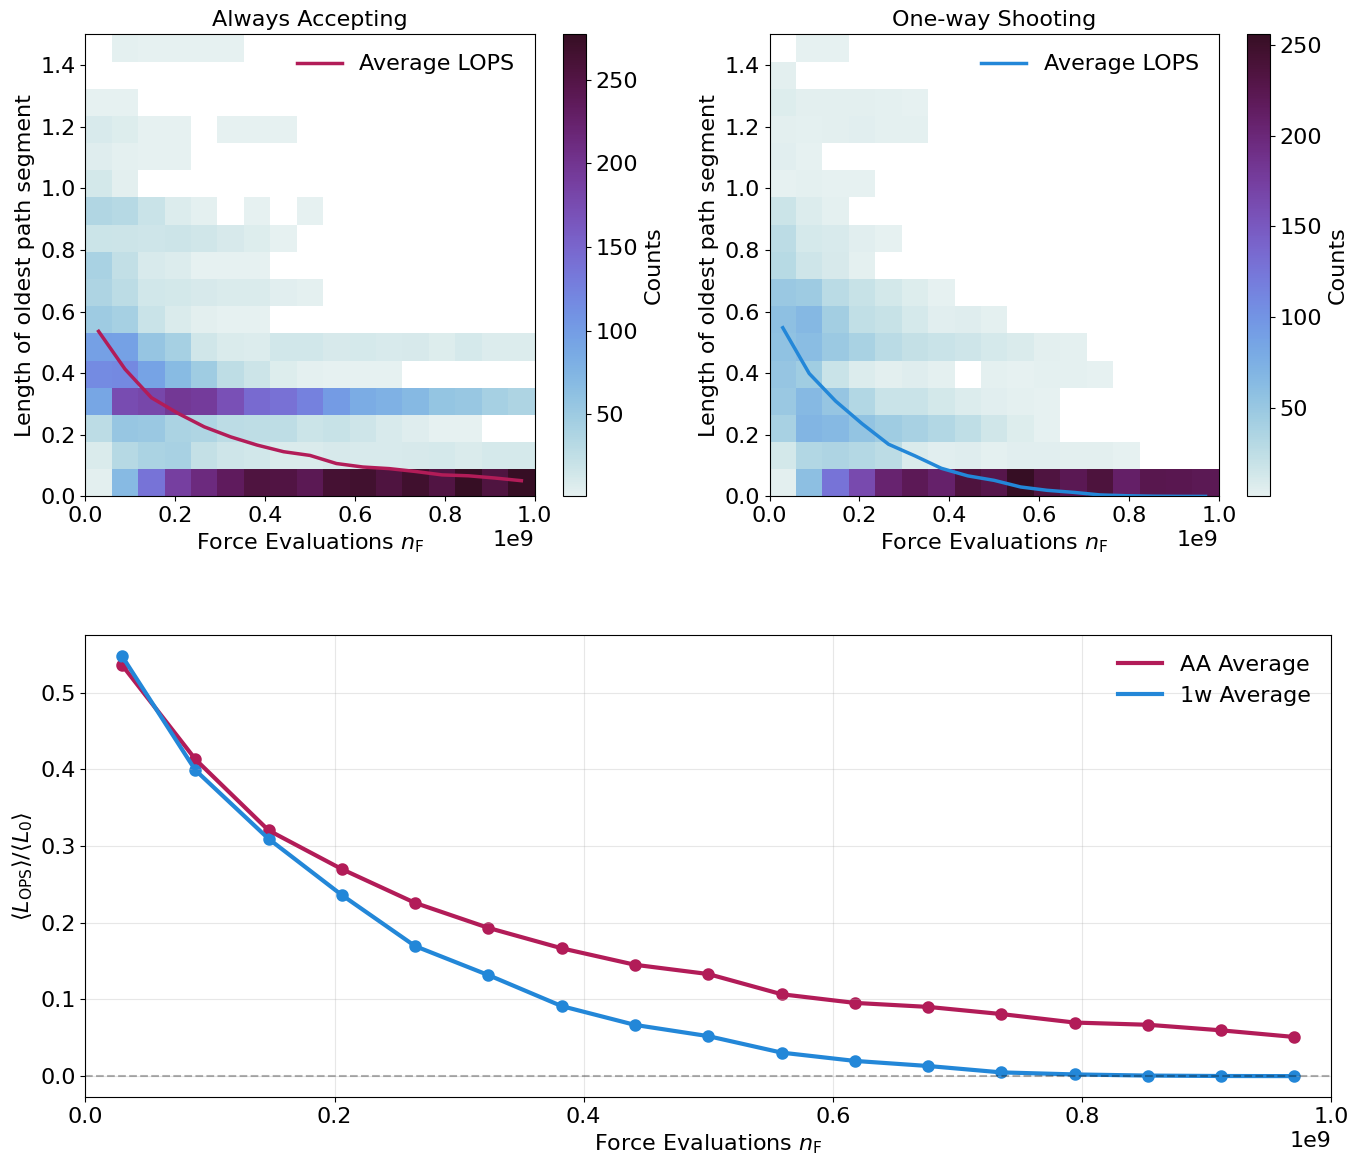

In [23]:
# Create figure with 3 subplots: 2 histograms + 1 comparison plot
fig = plt.figure(figsize=(14, 12))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[2, 2])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])  # Spans entire bottom row

# Function to plot histogram and return average line data
def plot_histogram(ax, data_path, title, color):
    # Load data
    loaded_data = np.load(data_path)
    counts = loaded_data['counts']
    xedges = loaded_data['xedges']
    yedges = loaded_data['yedges']
    bin_centers = loaded_data['bin_centers']
    bin_means = loaded_data['bin_means']
    mask = loaded_data['mask']
    
    # Create masked array
    masked_counts = np.ma.masked_where(counts == 0, counts)
    
    # Create meshgrid
    X, Y = np.meshgrid(xedges, yedges)
    
    # Plot histogram
    pcm = ax.pcolormesh(X, Y, masked_counts.T, cmap=mpl_cm, shading='auto')
    fig.colorbar(pcm, ax=ax, label='Counts')
    
    # Plot average line
    ax.plot(bin_centers[mask], bin_means[mask], c=color, 
            linewidth=2.5, label='Average LOPS')
    
    # Add labels and title
    ax.set_xlabel(r'Force Evaluations $n_\mathrm{F}$')
    ax.set_ylabel('Length of oldest path segment')
    ax.set_title(title)
    ax.legend()

    #ax.set_xlim(0, 10e8)
    #ax.set_ylim(0, 0.2)
    
    # Return average line data for comparison plot
    return bin_centers[mask], bin_means[mask], color

# Plot first histogram (top-left)
centers1, means1, color1 = plot_histogram(ax1, 'data/histogram_data_AA.npz', 
                                          'Always Accepting', cmap_colors[30])

centers2, means2, color2 = plot_histogram(ax2, 'data/histogram_data_1w.npz', 
                                          'One-way Shooting', cmap_colors[80])

ax3.plot(centers1, means1, color=color1, linewidth=3, label='AA Average')
ax3.plot(centers2, means2, color=color2, linewidth=3, label='1w Average')
ax3.scatter(centers1, means1, color=color1, linewidth=3)
ax3.scatter(centers2, means2, color=color2, linewidth=3)

#ax3.plot(xAA, avg_length_padded_AA / avg_full_path_length_AA, 'o-', ms = 6, color=cmap_colors[30], alpha=0.8, label='_nolegend_')
#ax3.plot(x1w, avg_length_padded_1w / avg_full_path_length_1w, 'o-', ms = 6, c=cmap_colors[80], alpha=0.8, label='_nolegend_')

#ax3.fill_between(xAA, 
#                (avg_length_padded_AA / avg_full_path_length_AA) - (std_error_padded_AA / avg_full_path_length_AA),
#                (avg_length_padded_AA / avg_full_path_length_AA) + (std_error_padded_AA / avg_full_path_length_AA),
#                color=cmap_colors[30], alpha=0.15, label='_nolegend_')

#ax3.fill_between(x1w, 
#                (avg_length_padded_1w / avg_full_path_length_1w) - (std_error_padded_1w / avg_full_path_length_1w),
#                (avg_length_padded_1w / avg_full_path_length_1w) + (std_error_padded_1w / avg_full_path_length_1w),
#                color=cmap_colors[80], alpha=0.15, label='_nolegend_')

ax3.set_xlabel(r'Force Evaluations $n_\mathrm{F}$')
ax3.set_ylabel(r'$\langle L_\mathrm{OPS} \rangle / \langle L_0\rangle$')
ax3.grid(alpha=0.3)
ax3.legend()

ax3.axhline(y=0, color='k', linestyle='--', alpha=0.3)

ax3.set_xlim(0, 1e9)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)  # Add space between rows
plt.savefig('../figures/OPS_histogram_comparison.png')
plt.show()

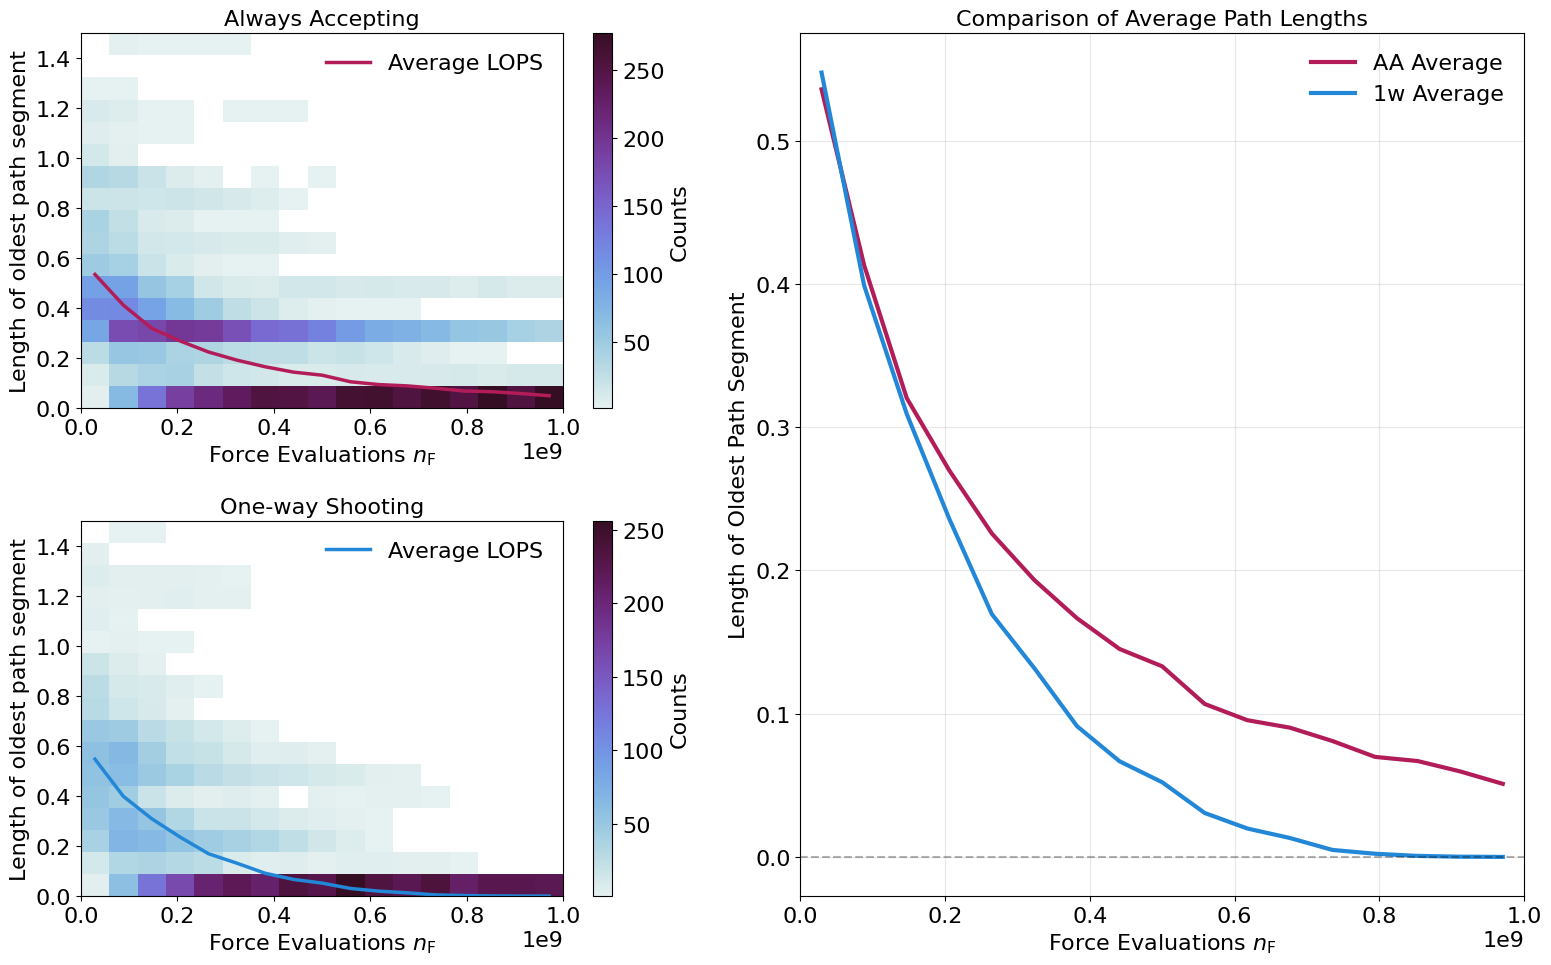

In [24]:
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1.2], height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])  # Top-left
ax2 = fig.add_subplot(gs[1, 0])  # Bottom-left
ax3 = fig.add_subplot(gs[:, 1])  # Entire right column

# Function to plot histogram and return average line data
def plot_histogram(ax, data_path, title, color):
    # Load data
    loaded_data = np.load(data_path)
    counts = loaded_data['counts']
    xedges = loaded_data['xedges']
    yedges = loaded_data['yedges']
    bin_centers = loaded_data['bin_centers']
    bin_means = loaded_data['bin_means']
    mask = loaded_data['mask']
    
    # Create masked array
    masked_counts = np.ma.masked_where(counts == 0, counts)
    
    # Create meshgrid
    X, Y = np.meshgrid(xedges, yedges)
    
    # Plot histogram
    pcm = ax.pcolormesh(X, Y, masked_counts.T, cmap=mpl_cm, shading='auto')
    fig.colorbar(pcm, ax=ax, label='Counts')
    
    # Plot average line
    ax.plot(bin_centers[mask], bin_means[mask], c=color, 
            linewidth=2.5, label='Average LOPS')
    
    # Add labels and title
    ax.set_xlabel(r'Force Evaluations $n_\mathrm{F}$')
    ax.set_ylabel('Length of oldest path segment')
    ax.set_title(title)
    ax.legend()

    #ax.set_xlim(0, 10e8)
    #ax.set_ylim(0, 0.2)
    
    # Return average line data for comparison plot
    return bin_centers[mask], bin_means[mask], color

# Plot first histogram (top-left)
centers1, means1, color1 = plot_histogram(ax1, 'data/histogram_data_AA.npz', 
                                          'Always Accepting', cmap_colors[30])

centers2, means2, color2 = plot_histogram(ax2, 'data/histogram_data_1w.npz', 
                                          'One-way Shooting', cmap_colors[80])

ax3.plot(centers1, means1, color=color1, linewidth=3, label='AA Average')
ax3.plot(centers2, means2, color=color2, linewidth=3, label='1w Average')

ax3.set_xlabel(r'Force Evaluations $n_\mathrm{F}$')
ax3.set_ylabel('Length of Oldest Path Segment')
ax3.set_title('Comparison of Average Path Lengths')
ax3.grid(alpha=0.3)
ax3.legend()

ax3.axhline(y=0, color='k', linestyle='--', alpha=0.3)

ax3.set_xlim(0, 1e9)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)  # Add space between rows
plt.show()

In [25]:
plt.rcParams.update({
    'font.size':18
})


/scratch_local/ipykernel_1678737/2264491316.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


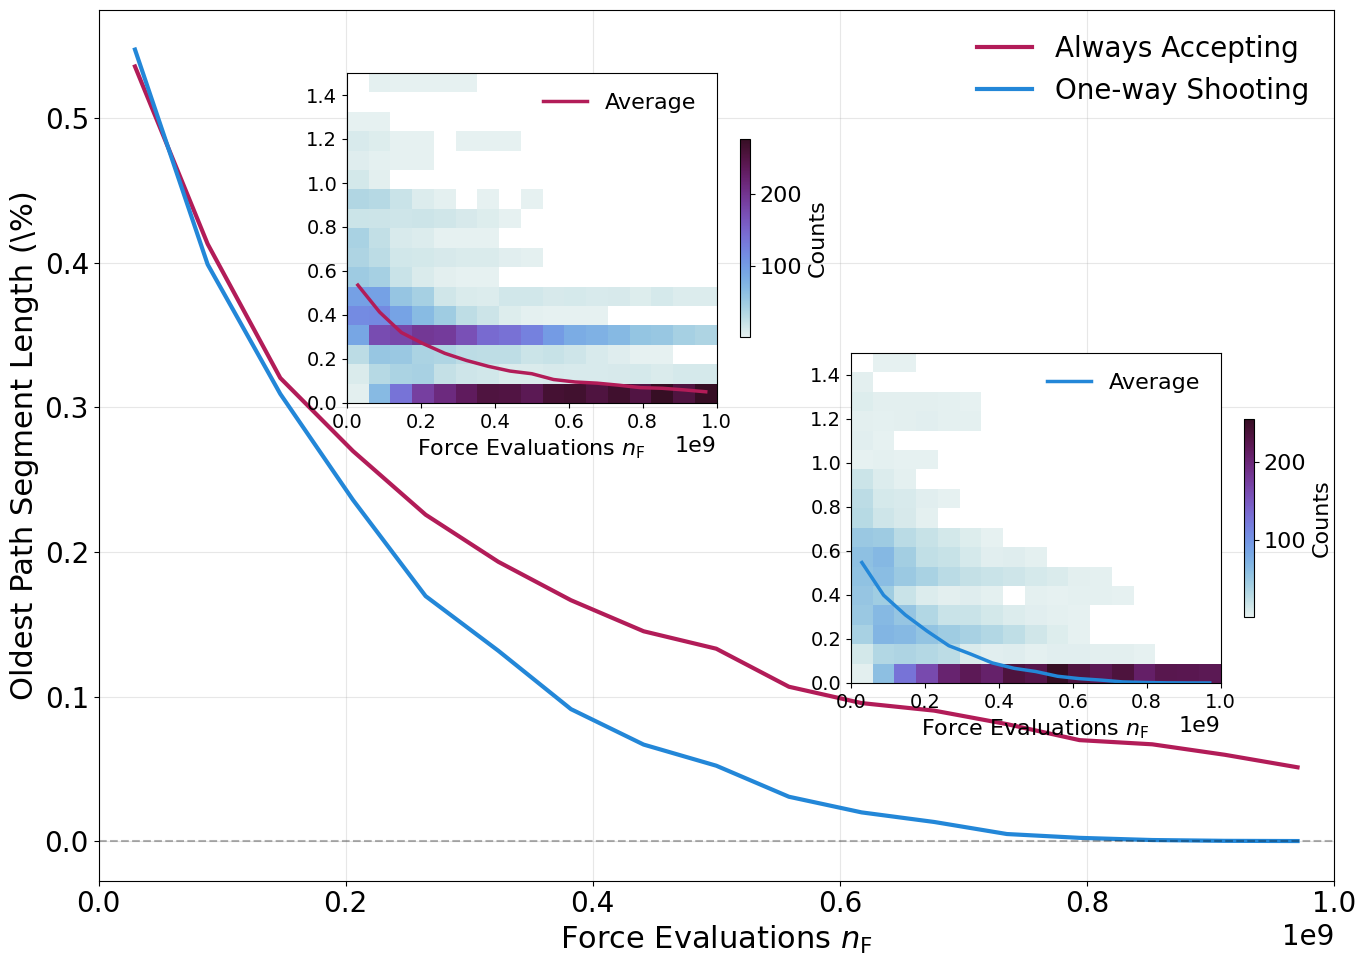

In [26]:
fig = plt.figure(figsize=(14, 10))
ax3 = fig.add_subplot(111)  # Main plot

def plot_histogram(ax, data_path, title, color, inset=False):
    loaded_data = np.load(data_path)
    counts = loaded_data['counts']
    xedges = loaded_data['xedges']
    yedges = loaded_data['yedges']
    bin_centers = loaded_data['bin_centers']
    bin_means = loaded_data['bin_means']
    mask = loaded_data['mask']

    masked_counts = np.ma.masked_where(counts == 0, counts)
    X, Y = np.meshgrid(xedges, yedges)

    pcm = ax.pcolormesh(X, Y, masked_counts.T, cmap=mpl_cm, shading='auto')
    fig.colorbar(pcm, ax=ax, label='Counts', shrink=0.6 if inset else 1.0)

    ax.plot(bin_centers[mask], bin_means[mask], c=color, linewidth=2.5, label='Average')

    ax.set_xlabel(r'Force Evaluations $n_\mathrm{F}$')
    #ax.set_ylabel('Length of oldest path segment')
    #ax.set_title(title, fontsize=10 if inset else 12)
    ax.legend(fontsize=16 if inset else 14)

    if inset:
        ax.tick_params(labelsize=14)
    else:
        ax.tick_params(labelsize=20)
    return bin_centers[mask], bin_means[mask], color

# Main average comparison plot in ax3
centers1, means1, color1 = plot_histogram(
    ax=plt.axes([0.26, 0.58, 0.33, 0.33]),  # [left, bottom, width, height]
    data_path='data/histogram_data_AA.npz',
    title='Always Accepting',
    color=cmap_colors[30],
    inset=True
)

centers2, means2, color2 = plot_histogram(
    ax=plt.axes([0.62, 0.3, 0.33, 0.33]),  
    data_path='data/histogram_data_1w.npz',
    title='One-way Shooting',
    color=cmap_colors[80],
    inset=True
)

ax3.tick_params(labelsize=20)
ax3.xaxis.get_offset_text().set_fontsize(20)

ax3.plot(centers1, means1, color=color1, linewidth=3, label='Always Accepting')
ax3.plot(centers2, means2, color=color2, linewidth=3, label='One-way Shooting')

ax3.set_xlabel(r'Force Evaluations $n_\mathrm{F}$', fontsize = 22)
ax3.set_ylabel(r'Oldest Path Segment Length (\%)', fontsize = 22)
ax3.grid(alpha=0.3)
ax3.legend(fontsize = 20)

ax3.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax3.set_xlim(0, 1e9)

plt.tight_layout()
#plt.savefig('../figures/OPS_histogram_comparison.png')
plt.show()


In [27]:
with open('data/LOPS_AA', 'rb') as f:
    lengths_of_oldest_path_AA = pickle.load(f)
with open('data/LOPS_1w', 'rb') as f:
    lengths_of_oldest_path_1w = pickle.load(f)


In [28]:
from scipy.stats import sem

def average_length_with_blocking(length_list, n_blocks=10):
    """
    Calculate average path lengths with blocking-based error estimation
    to account for potential correlations in the data.
    
    Args:
        length_list: List of lists containing path lengths
        n_blocks: Number of blocks for statistical blocking
    
    Returns:
        avg_length: Array of average lengths
        blocked_error: Array of standard errors using blocking
    """
    # Determine maximum length across all runs
    max_len = max(len(run) for run in length_list)
    
    # Initialize arrays
    avg_length = np.full(max_len, np.nan)
    blocked_error = np.full(max_len, np.nan)
    
    # Process each time point k
    for k in range(max_len):
        # Extract values for current k from all runs that have it
        values = [run[k] for run in length_list if k < len(run)]
        
        if not values:
            continue  # Skip if no data
            
        n = len(values)
        avg_length[k] = np.mean(values)
        
        # Only calculate error if we have enough data
        if n > 1:
            # Apply statistical blocking to account for correlations
            block_size = max(1, n // n_blocks)
            block_means = []
            
            # Calculate block means
            for i in range(0, n, block_size):
                block = values[i:i+block_size]
                if block:  # Only add if block has data
                    block_means.append(np.mean(block))
            
            # Compute standard error from block means
            if len(block_means) > 1:
                blocked_error[k] = np.std(block_means, ddof=1) / np.sqrt(len(block_means))
            else:
                # Fallback to standard SEM if not enough blocks
                blocked_error[k] = np.std(values, ddof=1) / np.sqrt(n)
    
    return avg_length, blocked_error

In [29]:
avg_length_AA, std_error_AA = average_length_with_blocking(lengths_of_oldest_path_AA) 

In [30]:
avg_length_1w, std_error_1w = average_length_with_blocking(lengths_of_oldest_path_1w)

In [31]:
plt.rcParams.update({
    'axes.grid': True
})

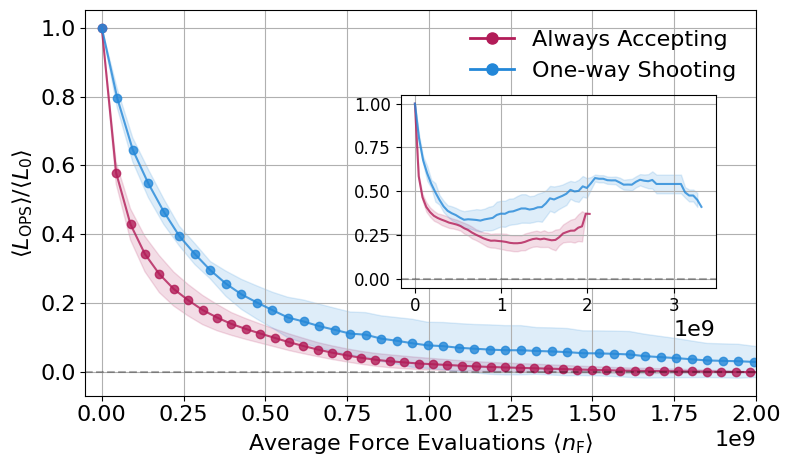

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))

# Main Plot Data
xAA = (np.arange(len(avg_length_padded_AA))) * avg_force_eval_per_trial_AA
x1w = (np.arange(len(avg_length_padded_1w))) * avg_force_eval_per_trial_1w

# Main Plot
ax.plot(xAA, avg_length_padded_AA, 'o-', ms = 6, color=cmap_colors[30], alpha=0.8, label='_nolegend_')
ax.plot(x1w, avg_length_padded_1w, 'o-', ms = 6, c=cmap_colors[80], alpha=0.8, label='_nolegend_')
#ax.scatter(xAA, avg_length_padded_AA, color=cmap_colors[30], alpha=0.8, lw = 0.5)
#ax.scatter(x1w, avg_length_padded_1w, c=cmap_colors[80], alpha=0.8)

ax.fill_between(xAA, 
                (avg_length_padded_AA) - (std_error_padded_AA),
                (avg_length_padded_AA) + (std_error_padded_AA),
                color=cmap_colors[30], alpha=0.15, label='_nolegend_')

ax.fill_between(x1w, 
                (avg_length_padded_1w) - (std_error_padded_1w),
                (avg_length_padded_1w) + (std_error_padded_1w),
                color=cmap_colors[80], alpha=0.15, label='_nolegend_')

ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)

#ax.axvline(x=avg_age_AA * avg_force_eval_per_trial_AA, color=cmap_colors[30], linestyle='--', alpha=0.6, label = '_nolegend_')
#ax.axvline(x=avg_age_1w * avg_force_eval_per_trial_1w, color=cmap_colors[80], linestyle='--', alpha=0.6, label = '_nolegend_')



ax.set_xlabel(r'Average Force Evaluations $\langle n_\mathrm{F} \rangle$')
ax.set_ylabel(r'$\langle L_\mathrm{OPS} \rangle / \langle L_0\rangle$')

#plt.legend(ncols = 2)
legend_elements = [
    Line2D([0], [0], color=cmap_colors[30], 
           marker='o', markersize=8, linestyle='-', lw=2,
           label='Always Accepting'),
    Line2D([0], [0], color=cmap_colors[80], 
           marker='o', markersize=8, linestyle='-', lw=2,
           label='One-way Shooting'),
   #Line2D([0], [0], color='gray', linestyle='--', lw=2, 
           #label='Average Age')
]
ax.legend(handles=legend_elements)
plt.tight_layout()
plt.xlim(-0.5e8, 0.2e10)

# === Inset Plot === #

inset_ax = ax.inset_axes([0.47, 0.28, 0.47, 0.5])  # [left, bottom, width, height] in axes fraction

xAA_inset = (np.arange(len(avg_length_AA))) * avg_force_eval_per_trial_AA
x1w_inset = (np.arange(len(avg_length_1w))) * avg_force_eval_per_trial_1w

# AA
inset_ax.fill_between(xAA_inset, 
                      avg_length_AA  - std_error_AA,
                      avg_length_AA  + std_error_AA,
                      color=cmap_colors[30], alpha=0.15, label='_nolegend_')
inset_ax.plot(xAA_inset, avg_length_AA, color=cmap_colors[30], alpha=0.8)
#inset_ax.scatter(xAA_inset, avg_length_AA, color=cmap_colors[30], alpha=0.8, linewidths=0.01)

# 1w
inset_ax.fill_between(x1w_inset, 
                      avg_length_1w  - std_error_1w,
                      avg_length_1w  + std_error_1w,
                      color=cmap_colors[80], alpha=0.15, label='_nolegend_')
inset_ax.plot(x1w_inset, avg_length_1w  , color=cmap_colors[80], alpha=0.8)
#inset_ax.scatter(x1w_inset, avg_length_1w, color=cmap_colors[80], alpha=0.8, marker='o', linewidths=0.1)

inset_ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)

inset_ax.tick_params(labelsize=12)

# Optional: Clean up inset axes
#inset_ax.set_xticks([])
#inset_ax.set_yticks([])
#inset_ax.set_title("Oldest Segment Age (µs)", fontsize=8)

# === Save === #
plt.savefig(f'../figures/oldest_path_segment_length.png')


In [33]:
plt.rcParams.update({
    'axes.grid':False
})


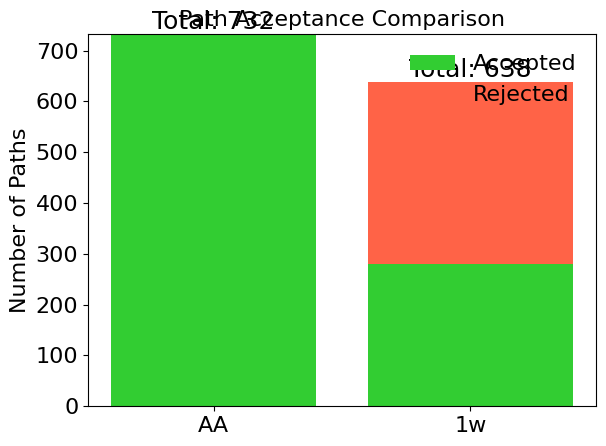

In [34]:
# Data
methods = ['AA', '1w']
accepted = [732, 280]
rejected = [0, 358]  # 638 - 280

fig, ax = plt.subplots()
ax.bar(methods, accepted, label='Accepted', color='limegreen')
ax.bar(methods, rejected, bottom=accepted, label='Rejected', color='tomato')

ax.set_ylabel('Number of Paths')
ax.set_title('Path Acceptance Comparison')
ax.legend()

# Add total labels on top
for i, method in enumerate(methods):
    total = accepted[i] + rejected[i]
    ax.text(i, total + 10, f'Total: {total}', ha='center')

plt.ylim
plt.tight_layout()
plt.show()

plt.show()
plt.rcParams.update({
    'axes.grid':True
})


## Counts

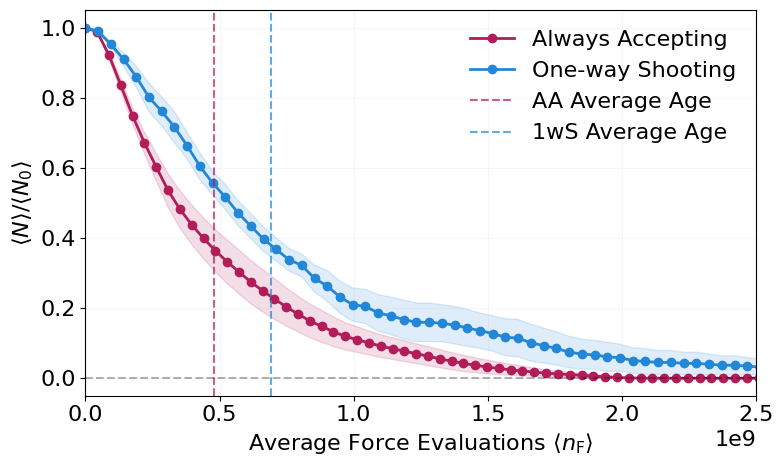

In [35]:
def calculate_block_fractions(Ls_padded, n_blocks):
    """
    Calculate fraction of alive paths per iteration with blocking statistics
    Returns: x, mean_fraction, std_error
    """
    # Split into blocks along the first axis
    blocks = np.array_split(Ls_padded, n_blocks, axis=0)
    
    fractions = []
    for block in blocks:
        # Count alive paths (non-zero) at each iteration
        alive_counts = np.count_nonzero(block, axis=0)
        # Calculate fraction alive
        fractions.append(alive_counts / len(block))
    
    fractions = np.array(fractions)
    mean_fraction = np.mean(fractions, axis=0)
    std_error = np.std(fractions, axis=0, ddof=1) / np.sqrt(n_blocks)
    
    return np.arange(Ls_padded.shape[1]), mean_fraction, std_error

# Set number of blocks for statistics
n_blocks = 7  # Adjust based on your data size

# Calculate blocked statistics for both methods
iterations_AA, mean_frac_AA, error_AA = calculate_block_fractions(Ls_padded_AA_, n_blocks)
iterations_1w, mean_frac_1w, error_1w = calculate_block_fractions(Ls_padded_1w_, n_blocks)

# Convert iterations to force evaluations
x_AA = (iterations_AA ) * avg_force_eval_per_trial_AA
x_1w = (iterations_1w ) * avg_force_eval_per_trial_1w

# Create plot with error bands
fig, ax = plt.subplots(figsize=(8, 5))

# Plot AA with error band
plt.fill_between(x_AA, 
                 mean_frac_AA - error_AA,
                 mean_frac_AA + error_AA,
                 color=cmap_colors[30], alpha=0.15, label='_nolegend_')
plt.plot(x_AA, mean_frac_AA, 'o-', color=cmap_colors[30], 
         markersize=6, linewidth=2, label='Always Accepting')

# Plot 1wS with error band
plt.fill_between(x_1w, 
                 mean_frac_1w - error_1w,
                 mean_frac_1w + error_1w,
                 color=cmap_colors[80], alpha=0.15, label='_nolegend_')
plt.plot(x_1w, mean_frac_1w, 'o-', color=cmap_colors[80], 
         markersize=6, linewidth=2, label='One-way Shooting')

# Add horizontal line at zero
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Add vertical lines for average ages
plt.axvline(x=avg_age_AA * avg_force_eval_per_trial_AA, 
            color=cmap_colors[30], linestyle='--', alpha=0.7, linewidth=1.5,
            label='AA Average Age')
plt.axvline(x=avg_age_1w * avg_force_eval_per_trial_1w, 
            color=cmap_colors[80], linestyle='--', alpha=0.7, linewidth=1.5,
            label='1wS Average Age')

# Configure plot
plt.ylabel(r'$\langle N \rangle / \langle N_0 \rangle$')
plt.xlabel(r'Average Force Evaluations $\langle n_\mathrm{F} \rangle$')
plt.grid(alpha=0.1, linestyle='-')
plt.legend(loc='best', framealpha=0.8)
plt.tight_layout()

# Set appropriate limits
plt.xlim(0, 0.25e10)
plt.ylim(bottom=-0.05)  # Slightly below 0 to see bands
#plt.axhline(0.1)
#plt.ylim(0.09, 0.11)
#plt.xlim(0.5e9, 1.28e9)
#plt.axvline(0.6e9)
#plt.axvline(1.19e9)

plt.savefig('../figures/surviving_paths_fraction_with_bands.png')
plt.show()